# Premier League — Transfer Spending vs Team Performance (2020–2024)
DSA210 — Term Project (ML milestone: Jan 2)

I’m curious about a super simple (and honestly kind of fun) question:

**Within a Premier League season, do teams that spend more on transfers end up performing better?**

I’m not trying to “prove” football is just money — I just want to see how much signal transfer spending gives us when we compare it with season-level performance stats (like goals scored, goals conceded, and goal difference).

What I’ll do in this notebook:
- Load transfer data + club season stats (two different sources → enrichment)
- Clean and align team names
- Build a **season-by-season** dataset (because each season has different teams)
- Do EDA + hypothesis tests
- Apply simple ML methods (baseline models) for the Jan 2 milestone
- Wrap up with limitations + future work

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, f1_score, roc_auc_score

## Data Sources (and how I’m using them)

I’m using **two different datasets**:

1) `premier-league.csv`  
This is the transfer dataset. I’ll compute, for each team and season:
- total incoming transfer spending

2) `20XX_season_club_stats.csv`  
These are season-level team stats from the Premier League website style data (goals, shots, etc).

Then I merge them **within the same season** using cleaned team names.

Important note:  
Transfer fees are taken as provided in the dataset. Some transfers have missing/zero fees (free transfers, loans, undisclosed), so “spending” is measured based on the available recorded fees.

In [9]:
TRANSFER_PATH = "data/premier-league.csv"

SEASON_STATS_PATHS = {
    "2020/2021": "data/2020_season_club_stats.csv",
    "2021/2022": "data/2021_season_club_stats.csv",
    "2022/2023": "data/2022_season_club_stats.csv",
}

transfer_raw = pd.read_csv(TRANSFER_PATH)
transfer_raw.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season
0,Middlesbrough FC,Tommy Wright,26.0,Left Winger,Leicester,€910Th.,in,Summer,0.91,Premier League,1992,1992/1993
1,Middlesbrough FC,Jonathan Gittens,28.0,defence,Southampton,€250Th.,in,Summer,0.25,Premier League,1992,1992/1993
2,Middlesbrough FC,Chris Morris,28.0,Right-Back,Celtic,?,in,Summer,NaN,Premier League,1992,1992/1993
3,Middlesbrough FC,Ben Roberts,17.0,Goalkeeper,Boro U18,-,in,Summer,NaN,Premier League,1992,1992/1993
4,Middlesbrough FC,Andy Todd,17.0,Centre-Back,Boro U18,-,in,Summer,NaN,Premier League,1992,1992/1993


In [3]:
transfer_raw.shape, transfer_raw.columns

((23498, 12),
 Index(['club_name', 'player_name', 'age', 'position', 'club_involved_name',
        'fee', 'transfer_movement', 'transfer_period', 'fee_cleaned',
        'league_name', 'year', 'season'],
       dtype='object'))

In [4]:
transfer_raw["transfer_movement"].value_counts(dropna=False).head(10)

,count
transfer_movement,
in,11852
out,11646


## Cleaning & Team Name Alignment

This part is honestly the “real data science” part 😅  
Different datasets write the same team differently (like **Arsenal** vs **Arsenal FC**, or **Brighton & Hove Albion** vs **Brighton and Hove Albion**).

So I normalize team names with a simple function:
- unify "&" → "and"
- remove common suffix tokens like FC/AFC
- collapse extra spaces

In [10]:
import re

def normalize_club(name: str) -> str:
    name = str(name)
    name = name.replace("&", "and")
    name = re.sub(r"\bFC\b", "", name)
    name = re.sub(r"\bAFC\b", "", name)
    name = re.sub(r"\bCF\b", "", name)
    name = re.sub(r"\bSC\b", "", name)
    name = re.sub(r"\bAC\b", "", name)
    name = re.sub(r"\bBC\b", "", name)
    name = re.sub(r"\s+", " ", name).strip()
    return name

transfer = transfer_raw.copy()
transfer["fee_cleaned"] = transfer["fee_cleaned"].fillna(0.0)
transfer["club_norm"] = transfer["club_name"].apply(normalize_club)
transfer["season"] = transfer["season"].astype(str)

transfer.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season,club_norm
0,Middlesbrough FC,Tommy Wright,26.0,Left Winger,Leicester,€910Th.,in,Summer,0.91,Premier League,1992,1992/1993,Middlesbrough
1,Middlesbrough FC,Jonathan Gittens,28.0,defence,Southampton,€250Th.,in,Summer,0.25,Premier League,1992,1992/1993,Middlesbrough
2,Middlesbrough FC,Chris Morris,28.0,Right-Back,Celtic,?,in,Summer,0.00,Premier League,1992,1992/1993,Middlesbrough
3,Middlesbrough FC,Ben Roberts,17.0,Goalkeeper,Boro U18,-,in,Summer,0.00,Premier League,1992,1992/1993,Middlesbrough
4,Middlesbrough FC,Andy Todd,17.0,Centre-Back,Boro U18,-,in,Summer,0.00,Premier League,1992,1992/1993,Middlesbrough


## Building a season dataset (team spending + season performance)

For each season:
- compute total incoming spending per club
- load that season’s club stats
- merge them using normalized club names
- create performance targets:
  - Goals
  - Goals Conceded
  - Goal Difference = Goals - Goals Conceded

I’m doing it **season-by-season** (not one big table), because the set of teams changes each year.

In [11]:
def build_season_df(season_str: str, stats_path: str) -> pd.DataFrame:
    season_transfers = transfer[(transfer["season"] == season_str) & (transfer["transfer_movement"] == "in")].copy()
    spending = (
        season_transfers
        .groupby("club_norm", as_index=False)["fee_cleaned"]
        .sum()
        .rename(columns={"fee_cleaned": "transfer_spend"})
    )

    stats_df = pd.read_csv(stats_path).copy()
    stats_df["club_norm"] = stats_df["club_name"].apply(normalize_club)
    stats_df["season"] = stats_df["season"].astype(str)

    merged = stats_df.merge(spending, on="club_norm", how="left")
    merged["transfer_spend"] = merged["transfer_spend"].fillna(0.0)

    merged["Goals"] = pd.to_numeric(merged["Goals"], errors="coerce")
    merged["Goals Conceded"] = pd.to_numeric(merged["Goals Conceded"], errors="coerce")
    merged["Goal_Diff"] = merged["Goals"] - merged["Goals Conceded"]

    merged["season"] = season_str
    return merged

season_dfs = {s: build_season_df(s, p) for s, p in SEASON_STATS_PATHS.items()}
list(season_dfs.keys()), season_dfs["2020/2021"].shape

(['2020/2021', '2021/2022', '2022/2023'], (20, 37))

In [7]:
season_dfs["2020/2021"][["club_name", "transfer_spend", "Goals", "Goals Conceded", "Goal_Diff"]].head(10)

,club_name,transfer_spend,Goals,Goals Conceded,Goal_Diff
0,Arsenal,86.00,55,39,16
1,Aston Villa,101.35,55,46,9
2,Brighton and Hove Albion,28.50,40,46,-6
3,Burnley,1.10,33,55,-22
4,Chelsea,247.20,58,36,22
5,Crystal Palace,22.40,41,66,-25
6,Everton,73.37,47,48,-1
7,Fulham,37.25,27,53,-26
8,Leeds United,106.80,62,54,8
9,Leicester City,59.40,68,50,18


# Exploratory Data Analysis (EDA)

I’ll do the same basic EDA loop for each season:
- distribution of transfer spending
- scatter: spending vs goals
- scatter: spending vs goal difference
- quick correlation numbers

My mindset here is simple:
I’m not expecting spending to explain everything, but if there’s *some* relationship, it should show up as a trend.


Season: 2020/2021


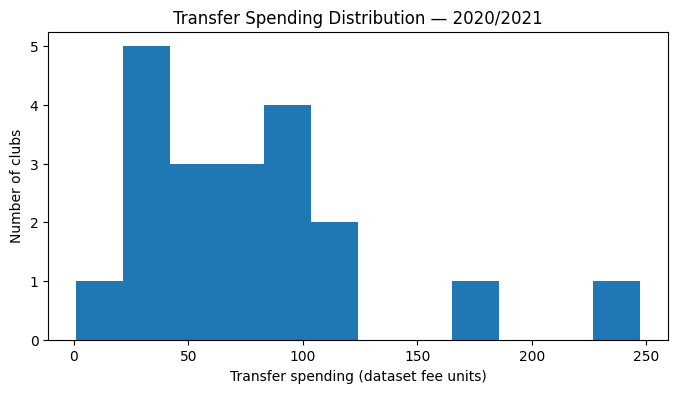

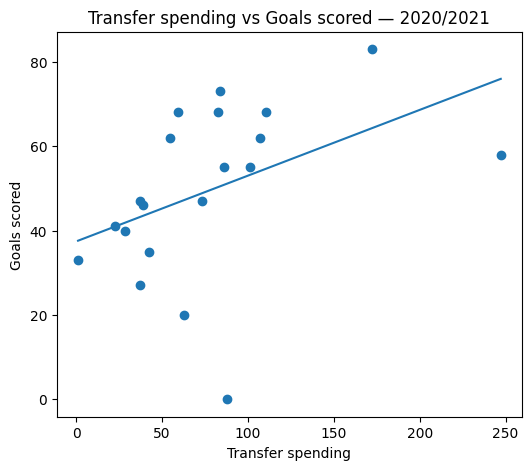

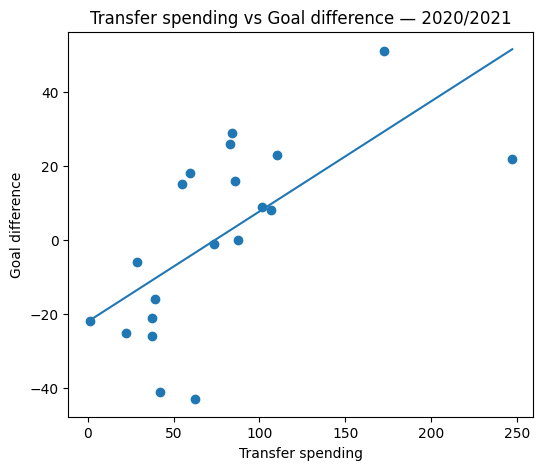

2020/2021 | Corr(spend, Goals) = 0.433 (p=0.0566)
2020/2021 | Corr(spend, Goals Conceded) = -0.492 (p=0.0277)
2020/2021 | Corr(spend, Goal_Diff) = 0.656 (p=0.0017)

Season: 2021/2022


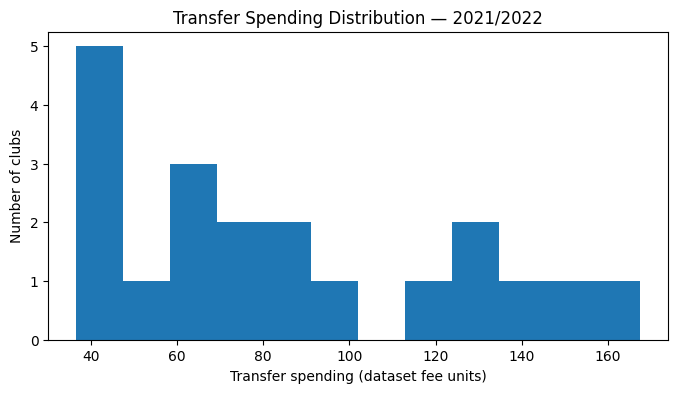

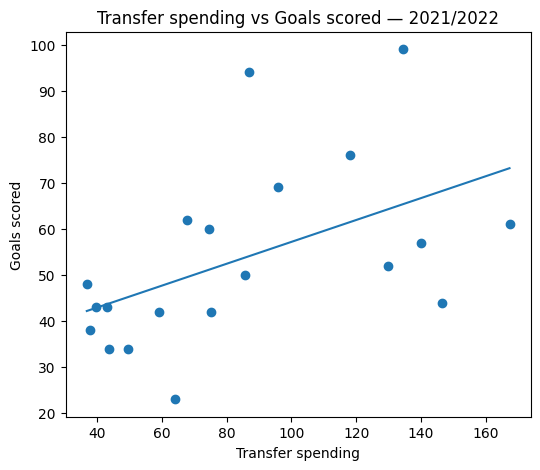

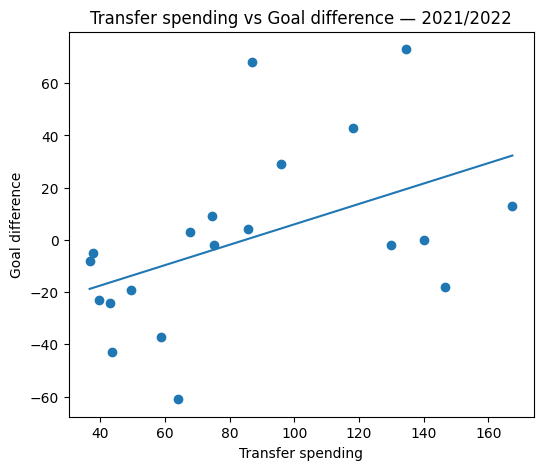

2021/2022 | Corr(spend, Goals) = 0.503 (p=0.0239)
2021/2022 | Corr(spend, Goals Conceded) = -0.390 (p=0.0893)
2021/2022 | Corr(spend, Goal_Diff) = 0.476 (p=0.0339)

Season: 2022/2023


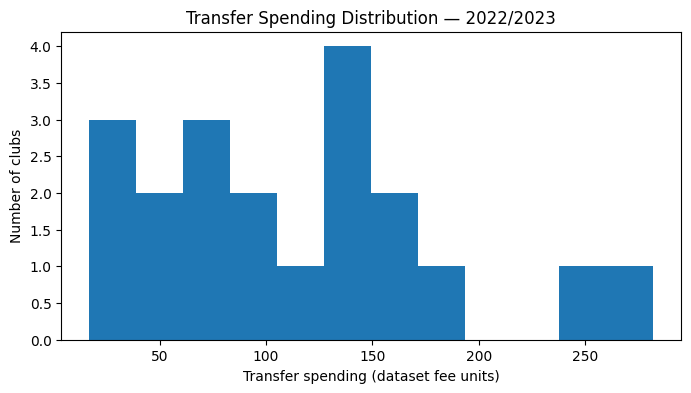

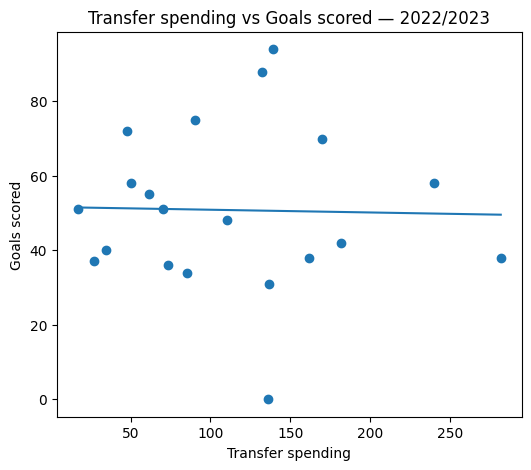

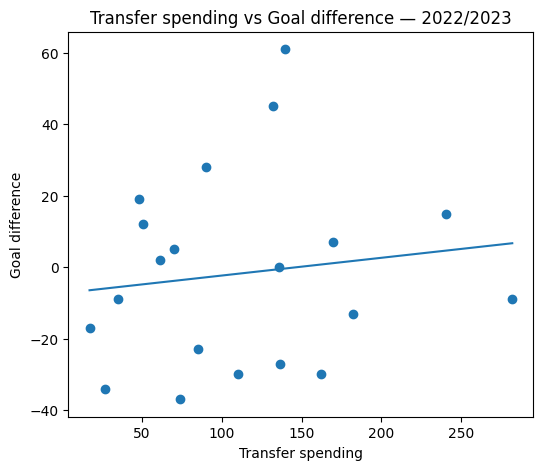

2022/2023 | Corr(spend, Goals) = -0.024 (p=0.9204)
2022/2023 | Corr(spend, Goals Conceded) = -0.237 (p=0.3146)
2022/2023 | Corr(spend, Goal_Diff) = 0.132 (p=0.5782)


In [12]:
def plot_spending_distribution(df, season):
    x = df["transfer_spend"].values
    plt.figure(figsize=(8,4))
    plt.hist(x, bins=12)
    plt.title(f"Transfer Spending Distribution — {season}")
    plt.xlabel("Transfer spending (dataset fee units)")
    plt.ylabel("Number of clubs")
    plt.show()

def scatter_with_line(df, xcol, ycol, season, xlabel, ylabel):
    x = df[xcol].values
    y = df[ycol].values

    plt.figure(figsize=(6,5))
    plt.scatter(x, y)
    plt.title(f"{xlabel} vs {ylabel} — {season}")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if np.std(x) > 0:
        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        ys = m*xs + b
        plt.plot(xs, ys)

    plt.show()

def corr_report(df, season):
    x = df["transfer_spend"].values
    for ycol in ["Goals", "Goals Conceded", "Goal_Diff"]:
        y = df[ycol].values
        r, p = stats.pearsonr(x, y)
        print(f"{season} | Corr(spend, {ycol}) = {r:.3f} (p={p:.4f})")

for s, df in season_dfs.items():
    print("\n" + "="*70)
    print("Season:", s)
    plot_spending_distribution(df, s)
    scatter_with_line(df, "transfer_spend", "Goals", s, "Transfer spending", "Goals scored")
    scatter_with_line(df, "transfer_spend", "Goal_Diff", s, "Transfer spending", "Goal difference")
    corr_report(df, s)

## First impressions (quick and honest)

At this point, I’m mostly looking for two things:
- Does spending *roughly* move with attacking output (goals)?
- Does spending look more connected to overall strength (goal difference)?

If the relationship changes from season to season, that’s not “bad news”.
It actually tells a nicer story: spending might help, but it’s not a guaranteed formula.

In [13]:
def quick_outlier_check(df, season, topk=3):
    top = df.sort_values("transfer_spend", ascending=False)[["club_name","transfer_spend","Goals","Goals Conceded","Goal_Diff"]].head(topk)
    bottom = df.sort_values("transfer_spend", ascending=True)[["club_name","transfer_spend","Goals","Goals Conceded","Goal_Diff"]].head(topk)
    print(f"\n{season} — Top {topk} spenders")
    display(top)
    print(f"\n{season} — Bottom {topk} spenders")
    display(bottom)

for s, df in season_dfs.items():
    quick_outlier_check(df, s, topk=3)


2020/2021 — Top 3 spenders


,club_name,transfer_spend,Goals,Goals Conceded,Goal_Diff
4,Chelsea,247.2,58,36,22
11,Manchester City,172.3,83,32,51
16,Tottenham Hotspur,110.5,68,45,23



2020/2021 — Bottom 3 spenders


,club_name,transfer_spend,Goals,Goals Conceded,Goal_Diff
3,Burnley,1.1,33,55,-22
5,Crystal Palace,22.4,41,66,-25
2,Brighton and Hove Albion,28.5,40,46,-6



2021/2022 — Top 3 spenders


,club_name,transfer_spend,Goals,Goals Conceded,Goal_Diff
0,Arsenal,167.42,61,48,13
13,Newcastle United,146.50,44,62,-18
12,Manchester United,140.00,57,57,0



2021/2022 — Bottom 3 spenders


,club_name,transfer_spend,Goals,Goals Conceded,Goal_Diff
2,Brentford,36.7,48,56,-8
19,Wolverhampton Wanderers,37.6,38,43,-5
7,Everton,39.5,43,66,-23



2022/2023 — Top 3 spenders


,club_name,transfer_spend,Goals,Goals Conceded,Goal_Diff
5,Chelsea,281.99,38,47,-9
13,Manchester United,240.33,58,43,15
18,West Ham United,182.00,42,55,-13



2022/2023 — Bottom 3 spenders


,club_name,transfer_spend,Goals,Goals Conceded,Goal_Diff
10,Leicester City,17.0,51,68,-17
2,Bournemouth,26.9,37,71,-34
6,Crystal Palace,34.6,40,49,-9


# Hypothesis Tests (per season)

Now I’ll do two simple tests for each season.

### Test 1 — High spenders vs low spenders (Goals)
I split teams into two groups using the **median spending** of that season:
- High spenders: spend > median
- Low spenders: spend ≤ median

Then I compare the **average goals scored** with an independent samples t-test.

### Test 2 — Spending vs Goal Difference (Correlation)
Goal difference is a nice “overall team strength” summary.
I test whether spending and goal difference are correlated in that season.

In [14]:
def hypothesis_tests(df, season):
    median_spend = df["transfer_spend"].median()

    high = df[df["transfer_spend"] > median_spend]["Goals"].dropna().values
    low  = df[df["transfer_spend"] <= median_spend]["Goals"].dropna().values

    t_stat, p_val = stats.ttest_ind(high, low, equal_var=False)

    x = df["transfer_spend"].values
    y = df["Goal_Diff"].values
    r, p_corr = stats.pearsonr(x, y)

    print("\n" + "-"*60)
    print(f"Season: {season}")
    print(f"Median spending threshold: {median_spend:.2f}")
    print(f"T-test (Goals, high vs low): t={t_stat:.3f}, p={p_val:.4f}")
    print(f"Pearson (Spend vs Goal_Diff): r={r:.3f}, p={p_corr:.4f}")

for s, df in season_dfs.items():
    hypothesis_tests(df, s)


------------------------------------------------------------
Season: 2020/2021
Median spending threshold: 68.03
T-test (Goals, high vs low): t=1.763, p=0.0976
Pearson (Spend vs Goal_Diff): r=0.656, p=0.0017

------------------------------------------------------------
Season: 2021/2022
Median spending threshold: 74.75
T-test (Goals, high vs low): t=2.960, p=0.0099
Pearson (Spend vs Goal_Diff): r=0.476, p=0.0339

------------------------------------------------------------
Season: 2022/2023
Median spending threshold: 100.22
T-test (Goals, high vs low): t=-0.020, p=0.9843
Pearson (Spend vs Goal_Diff): r=0.132, p=0.5782


# Machine Learning (Jan 2 milestone)

This ML part is intentionally simple.

Each season only has ~20 teams, so the goal is not a high-accuracy production model.
I’m using ML to answer a small practical question:

**Does transfer spending alone carry predictive signal about performance?**

I’ll try:
1) Regression → predict **Goal Difference**
2) Classification → predict whether **Goal Difference > 0**

In [15]:
def ml_per_season(df, season, random_state=42):
    X = df[["transfer_spend"]].values
    y_reg = df["Goal_Diff"].values
    y_clf = (df["Goal_Diff"] > 0).astype(int).values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_reg, test_size=0.3, random_state=random_state
    )

    lin = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ])
    lin.fit(X_train, y_train)
    pred = lin.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    rf = RandomForestRegressor(n_estimators=300, random_state=random_state)
    rf.fit(X_train, y_train)
    pred_rf = rf.predict(X_test)
    mae_rf = mean_absolute_error(y_test, pred_rf)
    r2_rf = r2_score(y_test, pred_rf)

    # classification
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        X, y_clf, test_size=0.3, random_state=random_state, stratify=y_clf
    )

    logreg = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=2000))
    ])
    logreg.fit(X_train_c, y_train_c)
    proba = logreg.predict_proba(X_test_c)[:, 1]
    pred_c = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_test_c, pred_c)
    f1 = f1_score(y_test_c, pred_c)
    auc = roc_auc_score(y_test_c, proba)

    return {
        "season": season,
        "lin_mae": mae,
        "lin_r2": r2,
        "rf_mae": mae_rf,
        "rf_r2": r2_rf,
        "log_acc": acc,
        "log_f1": f1,
        "log_auc": auc
    }

ml_rows = []
for s, df in season_dfs.items():
    res = ml_per_season(df, s)
    ml_rows.append(res)

ml_summary = pd.DataFrame(ml_rows).sort_values("season")
ml_summary

,season,lin_mae,lin_r2,rf_mae,rf_r2,log_acc,log_f1,log_auc
0,2020/2021,13.370494,0.303060,10.788333,0.600832,0.666667,0.666667,0.777778
1,2021/2022,25.095470,0.253152,17.860000,0.366108,0.333333,0.000000,0.500000
2,2022/2023,21.504334,-0.344418,23.032778,-0.523821,0.500000,0.000000,0.333333


# Putting everything into one neat summary

I want one table that summarizes:
- average spending
- correlation (spend vs goal difference)
- the p-value of the “high vs low spenders goals” t-test

So it’s easier to compare seasons side-by-side.

In [16]:
rows = []
for s, df in season_dfs.items():
    median_spend = df["transfer_spend"].median()

    high = df[df["transfer_spend"] > median_spend]["Goals"].dropna().values
    low  = df[df["transfer_spend"] <= median_spend]["Goals"].dropna().values
    _, p_t = stats.ttest_ind(high, low, equal_var=False)

    r, p_corr = stats.pearsonr(df["transfer_spend"].values, df["Goal_Diff"].values)

    rows.append({
        "season": s,
        "avg_spend": df["transfer_spend"].mean(),
        "median_spend": median_spend,
        "corr_spend_goal_diff": r,
        "corr_pvalue": p_corr,
        "ttest_pvalue_goals": p_t,
        "avg_goal_diff": df["Goal_Diff"].mean(),
        "avg_goals": df["Goals"].mean(),
        "avg_goals_conceded": df["Goals Conceded"].mean(),
    })

summary = pd.DataFrame(rows).sort_values("season")
summary

,season,avg_spend,median_spend,corr_spend_goal_diff,corr_pvalue,ttest_pvalue_goals,avg_goal_diff,avg_goals,avg_goals_conceded
0,2020/2021,76.8130,68.035,0.656063,0.001683,0.097620,0.80,49.40,48.60
1,2021/2022,84.7305,74.750,0.476032,0.033865,0.009930,0.00,53.55,53.55
2,2022/2023,112.3785,100.220,0.132304,0.578186,0.984308,-1.75,50.80,52.55


# Conclusion

Looking at the results across the three seasons, transfer spending does seem to help in
some cases, but it is clearly not a win factor.